In [1]:
import os
import math
import dill
from itertools import permutations

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib import gridspec
from sklearn.linear_model import HuberRegressor as hubreg
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from pingouin import mixed_anova, anova, pairwise_tukey
from statsmodels.regression.mixed_linear_model import MixedLM


import suite2p as s2p

import TwoPUtils as tpu
import STX3KO_analyses as stx
from STX3KO_analyses import utilities as u
from STX3KO_analyses.single_cell_stats import CellStats 

ko_mice = stx.ymaze_sess_deets.ko_mice
ctrl_mice = stx.ymaze_sess_deets.ctrl_mice


%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
# add permuted field detection

# field appearance and shift


In [3]:
figdir = "/mnt/BigDisk/YMazeResults/neural/wta_comparisons"
os.makedirs(figdir,exist_ok=True)

In [4]:
sess = u.load_single_day(ko_mice[0],0)

{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 6, 'scan': 14, 'novel_arm': -1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


In [23]:
class LMM_CellStats:

    def __init__(self, days = np.arange(6), ts_key = 'spks'):

        '''


        :param days:
        :param ts_key:
        '''

        self.ko_mice = stx.ymaze_sess_deets.ko_mice
        self.ctrl_mice = stx.ymaze_sess_deets.ctrl_mice
        self.__dict__.update({'days': days, 'days_z': sp.stats.zscore(days), 'ts_key': ts_key})
        self.n_days = days.shape[0]

        self.df = pd.DataFrame({'mouse':[],
                                'ko':[],
                                'day':[],
                                'dz': [],
                                'ko_x_day': [],
                                'lr':[], 
                                'novfam':[], 
                                'speed':[],
                                'avg_std': [],
                                'avg_skewness': [],
                                'avg_kurtosis': [],
                                'skewness': [],
                                'max_counts': [],
                                'field_width': []})
        self.fill_df()
#         self.df['speed'].apply(sp.stats.zscore)
        





    def fill_df(self):
        for mouse in self.ko_mice:
            for day, dz in zip(self.days,self.days_z):
                self.get_stats(u.load_single_day(mouse, day), 1, day, dz)
                
        for mouse in self.ctrl_mice:
            for day, dz in zip(self.days, self.days_z):
                self.get_stats(u.load_single_day(mouse,day),0, day, dz)
                
                
                

    def get_stats(self, sess, ko, day, dz, ts_key: str = 'spks'):
        '''

        :param sess:
        :param ts_key:
        :param fam:
        :return:
        '''
        
        for _arm, arm in enumerate([-1, 1]):
            trial_mask = sess.trial_info['LR']==arm
            if sess.novel_arm == arm:
                cell_mask = sess.nov_place_cell_mask()
                nov = 1
            else:
                cell_mask = sess.fam_place_cell_mask()
                nov = 0



            trial_mat = sess.trial_matrices[ts_key][:, :, cell_mask]
            trial_mat = trial_mat[trial_mask, :, :]
            trial_mat[np.isnan(trial_mat)] = 1E-5

            avg_trial_mat = trial_mat.mean(axis=0, keepdims = True)


            inds = np.arange(0, trial_mat.shape[1])[np.newaxis, :, np.newaxis]

            avg_trial_mat_norm = avg_trial_mat / (np.nansum(avg_trial_mat, axis=1, keepdims=True) + 1E-5)
            avg_com = (avg_trial_mat_norm * inds).sum(axis=1, keepdims=True)
            avg_std = np.power((np.power(inds - avg_com, 2) * avg_trial_mat_norm).sum(axis=1, keepdims=True), .5)
            avg_skewness = (np.power((inds - avg_com) / (avg_std + 1E-5), 3) * avg_trial_mat_norm).sum(axis=1)
            avg_kurtosis = (np.power((inds - avg_com) / (avg_std + 1E-5), 4) * avg_trial_mat_norm).sum(axis=1)
            
            trial_mat_sm = sp.ndimage.filters.gaussian_filter1d(trial_mat, 3, axis=0)
            trial_mat_sm_norm = trial_mat_sm / (np.nansum(trial_mat_sm, axis=1, keepdims=True) + 1E-5)
        
            com = (trial_mat_sm_norm * inds).sum(axis=1, keepdims=True)
            std = np.power((np.power(inds - com, 2) * trial_mat_sm_norm).sum(axis=1, keepdims=True), .5)

            skewness = (np.power((inds - com) / (std + 1E-5), 3) * trial_mat_sm_norm).sum(axis=1)
            kurtosis = (np.power((inds - com) / (std + 1E-5), 4) * trial_mat_sm_norm).sum(axis=1)

            self.df = self.df.append({'mouse': sess.mouse, 
                                    'ko': ko, 
                                    'day': day,
                                    'dz': dz,
                                    'ko_x_day': ko*dz,
                                    'lr': _arm, 
                                    'novfam': nov, 
                                    'avg_std': avg_std.mean(),
                                    'avg_skewness': avg_skewness.mean(),
                                    'skewness': skewness.mean(axis=0).mean(),
                                    'avg_kurtosis': avg_kurtosis.mean(),
                                    'max_counts': stx.spatial_analyses.max_counts(avg_trial_mat[0, :, :]).mean(),
                                    'field_width': np.nanmean(stx.spatial_analyses.field_width(avg_trial_mat[0, :, :]))}, ignore_index=True)
            

        

       


        

In [24]:
cell_stats = LMM_CellStats()

{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 6, 'scan': 14, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 6}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 0}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 9, 'novel_arm': 1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', '

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


In [25]:
lmm_res = MixedLM(cell_stats.df['avg_std'], cell_stats.df[['ko', 'dz', 'novfam', 'lr', 'ko_x_day']], cell_stats.df['mouse'])
lmm_resf = lmm_res.fit()
print(lmm_resf.summary())

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: avg_std 
No. Observations: 120     Method:             REML    
No. Groups:       10      Scale:              0.0305  
Min. group size:  12      Log-Likelihood:     -14.6130
Max. group size:  12      Converged:          Yes     
Mean group size:  12.0                                
------------------------------------------------------
           Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------
ko          8.069    2.576   3.132 0.002  3.020 13.118
dz         -0.039    0.023  -1.737 0.082 -0.083  0.005
novfam     -0.334    0.033 -10.270 0.000 -0.398 -0.270
lr          0.060    0.033   1.854 0.064 -0.003  0.124
ko_x_day    0.001    0.032   0.045 0.964 -0.061  0.064
Group Var  33.175   93.209                            



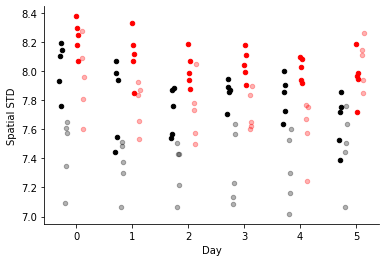

In [53]:
fig, ax = plt.subplots()

for m, mouse in enumerate(ctrl_mice):
    mask = (cell_stats.df['ko']==0) & (cell_stats.df['mouse'] == mouse)
    
    std = cell_stats.df['avg_std'].loc[mask & (cell_stats.df['novfam']==0)]
    x = cell_stats.df['day'].loc[mask & (cell_stats.df['novfam']==0)]
    ax.scatter(10*x+.1*m,std, color='black', s=20)
    
    std = cell_stats.df['avg_std'].loc[mask & (cell_stats.df['novfam']==1)]
    x = cell_stats.df['day'].loc[mask & (cell_stats.df['novfam']==1)]
    ax.scatter(10*x +.1*m + 1,std, color='black', alpha = .3, s=20)


for m, mouse in enumerate(ko_mice):
    mask = (cell_stats.df['ko']==1) & (cell_stats.df['mouse'] == mouse)
    
    std = cell_stats.df['avg_std'].loc[mask & (cell_stats.df['novfam']==0)]
    x = cell_stats.df['day'].loc[mask & (cell_stats.df['novfam']==0)]
    ax.scatter(10*x+.1*m + 3,std, color='red', s=20)
    
    std = cell_stats.df['avg_std'].loc[mask & (cell_stats.df['novfam']==1)]
    x = cell_stats.df['day'].loc[mask & (cell_stats.df['novfam']==1)]
    ax.scatter(10*x +.1*m + 4,std, color='red', alpha = .3, s=20)

ax.set_xticks(10.*np.arange(6) + 3)
ax.set_xticklabels(np.arange(6))
ax.set_xlabel('Day')

ax.set_ylabel('Spatial STD')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


fig.savefig(os.path.join(figdir, "avg_std_summary.pdf"))

In [55]:
lmm_res = MixedLM(cell_stats.df['max_counts'], cell_stats.df[['ko', 'day', 'novfam', 'lr', 'ko_x_day']], cell_stats.df['mouse'])
lmm_resf = lmm_res.fit()
print(lmm_resf.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: max_counts
No. Observations: 120     Method:             REML      
No. Groups:       10      Scale:              0.0451    
Min. group size:  12      Log-Likelihood:     -25.7209  
Max. group size:  12      Converged:          Yes       
Mean group size:  12.0                                  
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
ko             2.781    0.825  3.369 0.001  1.163  4.399
day           -0.082    0.016 -5.075 0.000 -0.113 -0.050
novfam         0.132    0.040  3.343 0.001  0.055  0.210
lr            -0.100    0.040 -2.533 0.011 -0.178 -0.023
ko_x_day      -0.015    0.039 -0.377 0.706 -0.091  0.061
Group Var      3.390    7.868                           



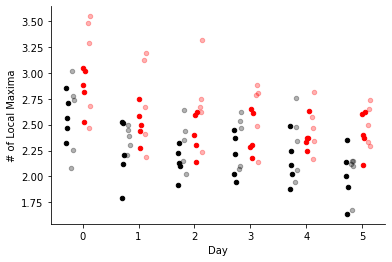

In [56]:
fig, ax = plt.subplots()

for m, mouse in enumerate(ctrl_mice):
    mask = (cell_stats.df['ko']==0) & (cell_stats.df['mouse'] == mouse)
    
    std = cell_stats.df['max_counts'].loc[mask & (cell_stats.df['novfam']==0)]
    x = cell_stats.df['day'].loc[mask & (cell_stats.df['novfam']==0)]
    ax.scatter(10*x+.1*m,std, color='black', s=20)
    
    std = cell_stats.df['max_counts'].loc[mask & (cell_stats.df['novfam']==1)]
    x = cell_stats.df['day'].loc[mask & (cell_stats.df['novfam']==1)]
    ax.scatter(10*x +.1*m + 1,std, color='black', alpha = .3, s=20)


for m, mouse in enumerate(ko_mice):
    mask = (cell_stats.df['ko']==1) & (cell_stats.df['mouse'] == mouse)
    
    std = cell_stats.df['max_counts'].loc[mask & (cell_stats.df['novfam']==0)]
    x = cell_stats.df['day'].loc[mask & (cell_stats.df['novfam']==0)]
    ax.scatter(10*x+.1*m + 3,std, color='red', s=20)
    
    std = cell_stats.df['max_counts'].loc[mask & (cell_stats.df['novfam']==1)]
    x = cell_stats.df['day'].loc[mask & (cell_stats.df['novfam']==1)]
    ax.scatter(10*x +.1*m + 4,std, color='red', alpha = .3, s=20)

ax.set_xticks(10.*np.arange(6) + 3)
ax.set_xticklabels(np.arange(6))
ax.set_xlabel('Day')

ax.set_ylabel('# of Local Maxima')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


fig.savefig(os.path.join(figdir, "max_counts_summary.pdf"))

In [57]:
lmm_res = MixedLM(cell_stats.df['field_width'], cell_stats.df[['ko', 'day', 'novfam', 'lr', 'ko_x_day']], cell_stats.df['mouse'])
lmm_resf = lmm_res.fit()
print(lmm_resf.summary())

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: field_width
No. Observations: 120     Method:             REML       
No. Groups:       10      Scale:              0.0703     
Min. group size:  12      Log-Likelihood:     -57.0870   
Max. group size:  12      Converged:          Yes        
Mean group size:  12.0                                   
----------------------------------------------------------
           Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
----------------------------------------------------------
ko          4.871     1.973   2.469  0.014   1.004   8.738
day         0.045     0.020   2.223  0.026   0.005   0.084
novfam     -0.172     0.049  -3.483  0.000  -0.269  -0.075
lr          0.306     0.049   6.181  0.000   0.209   0.402
ko_x_day   -0.069     0.048  -1.415  0.157  -0.163   0.026
Group Var  19.438    36.032                               



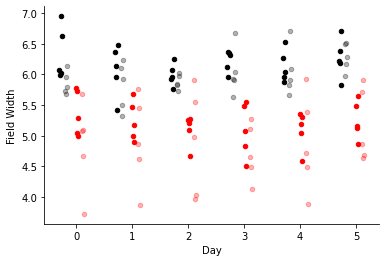

In [58]:
fig, ax = plt.subplots()

for m, mouse in enumerate(ctrl_mice):
    mask = (cell_stats.df['ko']==0) & (cell_stats.df['mouse'] == mouse)
    
    std = cell_stats.df['field_width'].loc[mask & (cell_stats.df['novfam']==0)]
    x = cell_stats.df['day'].loc[mask & (cell_stats.df['novfam']==0)]
    ax.scatter(10*x+.1*m,std, color='black', s=20)
    
    std = cell_stats.df['field_width'].loc[mask & (cell_stats.df['novfam']==1)]
    x = cell_stats.df['day'].loc[mask & (cell_stats.df['novfam']==1)]
    ax.scatter(10*x +.1*m + 1,std, color='black', alpha = .3, s=20)


for m, mouse in enumerate(ko_mice):
    mask = (cell_stats.df['ko']==1) & (cell_stats.df['mouse'] == mouse)
    
    std = cell_stats.df['field_width'].loc[mask & (cell_stats.df['novfam']==0)]
    x = cell_stats.df['day'].loc[mask & (cell_stats.df['novfam']==0)]
    ax.scatter(10*x+.1*m + 3,std, color='red', s=20)
    
    std = cell_stats.df['field_width'].loc[mask & (cell_stats.df['novfam']==1)]
    x = cell_stats.df['day'].loc[mask & (cell_stats.df['novfam']==1)]
    ax.scatter(10*x +.1*m + 4,std, color='red', alpha = .3, s=20)

ax.set_xticks(10.*np.arange(6) + 3)
ax.set_xticklabels(np.arange(6))
ax.set_xlabel('Day')

ax.set_ylabel('Field Width')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


fig.savefig(os.path.join(figdir, "field_width_summary.pdf"))

In [60]:
lmm_res = MixedLM(cell_stats.df['avg_skewness'], cell_stats.df[['ko', 'day', 'novfam', 'lr', 'ko_x_day']], cell_stats.df['mouse'])
lmm_resf = lmm_res.fit()
print(lmm_resf.summary())

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: avg_skewness
No. Observations: 120     Method:             REML        
No. Groups:       10      Scale:              0.0036      
Min. group size:  12      Log-Likelihood:     137.0885    
Max. group size:  12      Converged:          Yes         
Mean group size:  12.0                                    
-----------------------------------------------------------
            Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------
ko           0.021     0.036   0.595  0.552  -0.049   0.092
day         -0.003     0.004  -0.658  0.510  -0.012   0.006
novfam       0.001     0.011   0.125  0.901  -0.020   0.023
lr          -0.017     0.011  -1.497  0.134  -0.039   0.005
ko_x_day     0.003     0.011   0.311  0.756  -0.018   0.025
Group Var    0.005     0.048                               



/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [62]:
lmm_res = MixedLM(cell_stats.df['avg_kurtosis'], cell_stats.df[['ko', 'day', 'novfam', 'lr', 'ko_x_day']], cell_stats.df['mouse'])
lmm_resf = lmm_res.fit()
print(lmm_resf.summary())

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: avg_kurtosis
No. Observations: 120     Method:             REML        
No. Groups:       10      Scale:              0.0530      
Min. group size:  12      Log-Likelihood:     -34.9662    
Max. group size:  12      Converged:          Yes         
Mean group size:  12.0                                    
-----------------------------------------------------------
            Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------
ko           2.316     0.892   2.596  0.009   0.568   4.065
day          0.059     0.017   3.411  0.001   0.025   0.094
novfam       0.423     0.043   9.862  0.000   0.339   0.508
lr           0.048     0.043   1.123  0.261  -0.036   0.132
ko_x_day    -0.024     0.042  -0.580  0.562  -0.107   0.058
Group Var    3.960     8.480                               



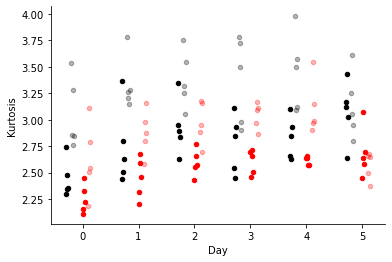

In [64]:
fig, ax = plt.subplots()

for m, mouse in enumerate(ctrl_mice):
    mask = (cell_stats.df['ko']==0) & (cell_stats.df['mouse'] == mouse)
    
    std = cell_stats.df['avg_kurtosis'].loc[mask & (cell_stats.df['novfam']==0)]
    x = cell_stats.df['day'].loc[mask & (cell_stats.df['novfam']==0)]
    ax.scatter(10*x+.1*m,std, color='black', s=20)
    
    std = cell_stats.df['avg_kurtosis'].loc[mask & (cell_stats.df['novfam']==1)]
    x = cell_stats.df['day'].loc[mask & (cell_stats.df['novfam']==1)]
    ax.scatter(10*x +.1*m + 1,std, color='black', alpha = .3, s=20)


for m, mouse in enumerate(ko_mice):
    mask = (cell_stats.df['ko']==1) & (cell_stats.df['mouse'] == mouse)
    
    std = cell_stats.df['avg_kurtosis'].loc[mask & (cell_stats.df['novfam']==0)]
    x = cell_stats.df['day'].loc[mask & (cell_stats.df['novfam']==0)]
    ax.scatter(10*x+.1*m + 3,std, color='red', s=20)
    
    std = cell_stats.df['avg_kurtosis'].loc[mask & (cell_stats.df['novfam']==1)]
    x = cell_stats.df['day'].loc[mask & (cell_stats.df['novfam']==1)]
    ax.scatter(10*x +.1*m + 4,std, color='red', alpha = .3, s=20)

ax.set_xticks(10.*np.arange(6) + 3)
ax.set_xticklabels(np.arange(6))
ax.set_xlabel('Day')

ax.set_ylabel('Kurtosis')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


fig.savefig(os.path.join(figdir, "kurtosis_summary.pdf"))

In [65]:
fam_cell_stats = CellStats(fam=True)

{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 6, 'scan': 14, 'novel_arm': -1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 6}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 0}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 9, 'novel_arm': 1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', '

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


In [ ]:
fig,ax = fam_cell_stats.violin_plots('avg_std')
fam_cell_stats.mixed_anova('avg_std')
# fig.savefig(os.path.join(figdir, 'fam_avg_std_violin.pdf'),format = 'pdf')

In [ ]:
fig, ax = fam_cell_stats.combined_hist('avg_std', cumulative=True, smooth=False)

# fig.savefig(os.path.join(figdir, 'fam_avg_std_cumhist.pdf'),format = 'pdf')

Mixed design ANOVA results
        Source         SS  DF1  DF2         MS          F     p-unc       np2  \
0      ko_ctrl  14.336115    1    8  14.336115  35.985124  0.000324  0.818120   
1          day   0.582437    5   40   0.116487   2.355670  0.057728  0.227476   
2  Interaction   0.141910    5   40   0.028382   0.573955  0.719501  0.066942   

        eps  
0       NaN  
1  0.492613  
2       NaN  
PostHoc Tukey: KO vs Ctrl
   A  B   mean(A)   mean(B)     diff        se          T  p-tukey    hedges
0  0  1  5.192308  6.169928 -0.97762  0.082277 -11.882068    0.001 -3.028094
PostHov Tukey on each day
Day 0
   A  B   mean(A)   mean(B)      diff        se         T   p-tukey    hedges
0  0  1  5.367639  6.331645 -0.964006  0.254744 -3.784218  0.005354 -2.161735
Day 1
   A  B   mean(A)   mean(B)      diff        se         T   p-tukey    hedges
0  0  1  5.243142  6.075245 -0.832103  0.237217 -3.507776  0.007987 -2.003817
Day 2
   A  B   mean(A)   mean(B)     diff        se        T 

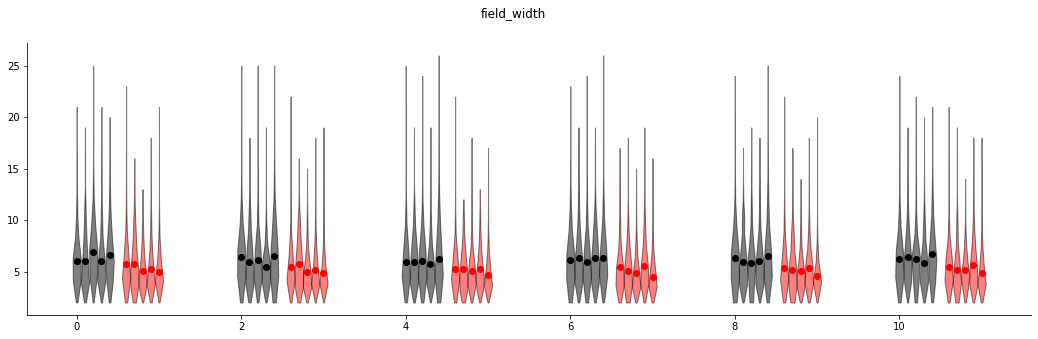

In [38]:
fig,ax = fam_cell_stats.violin_plots('field_width')
fam_cell_stats.mixed_anova('field_width')
fig.savefig(os.path.join(figdir, 'fam_field_width_violin.pdf'),format = 'pdf')

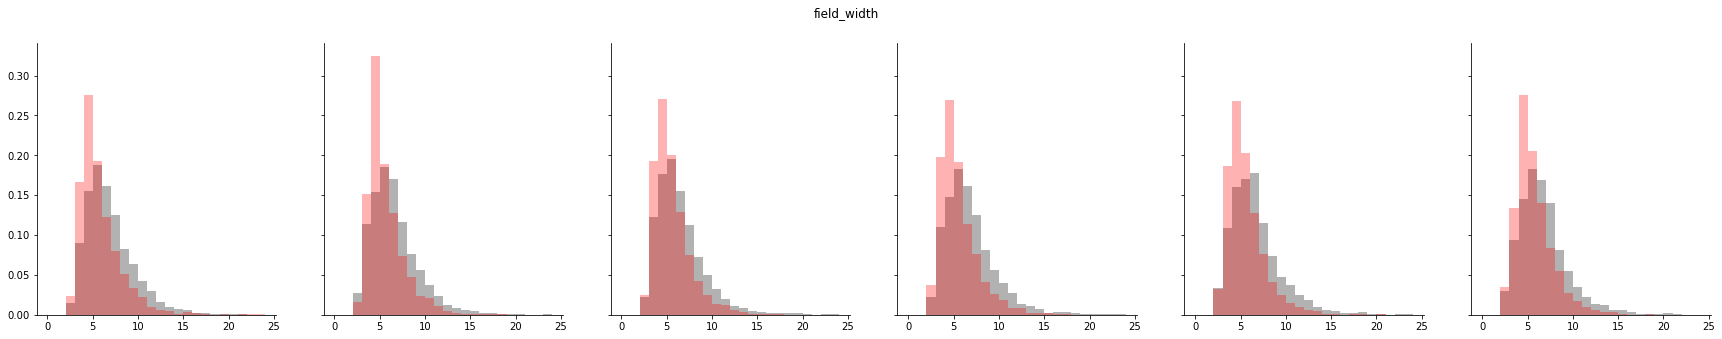

In [39]:
fig, ax = fam_cell_stats.combined_hist('field_width', cumulative=False, smooth=False, bins = np.arange(0,25))
fig.savefig(os.path.join(figdir, 'fam_field_width_hist.pdf'),format = 'pdf')

Mixed design ANOVA results
        Source        SS  DF1  DF2        MS          F     p-unc       np2  \
0      ko_ctrl  4.445098    1    8  4.445098  11.549300  0.009382  0.590778   
1          day  0.303769    5   40  0.060754   2.641098  0.037295  0.248198   
2  Interaction  0.069918    5   40  0.013984   0.607897  0.694253  0.070621   

        eps  
0       NaN  
1  0.642877  
2       NaN  
PostHoc Tukey: KO vs Ctrl
   A  B  mean(A)   mean(B)      diff        se         T  p-tukey    hedges
0  0  1  2.46477  1.920398  0.544371  0.070896  7.678421    0.001  1.956812
PostHov Tukey on each day
Day 0
   A  B   mean(A)  mean(B)      diff        se         T   p-tukey   hedges
0  0  1  2.554116   2.1442  0.409915  0.143638  2.853811  0.021353  1.63024
Day 1
   A  B   mean(A)   mean(B)      diff        se         T   p-tukey    hedges
0  0  1  2.427825  1.907329  0.520495  0.165351  3.147821  0.013643  1.798193
Day 2
   A  B   mean(A)   mean(B)      diff        se         T  p-tukey    

{'anova':         Source        SS  DF1  DF2        MS          F     p-unc       np2  \
 0      ko_ctrl  4.445098    1    8  4.445098  11.549300  0.009382  0.590778   
 1          day  0.303769    5   40  0.060754   2.641098  0.037295  0.248198   
 2  Interaction  0.069918    5   40  0.013984   0.607897  0.694253  0.070621   
 
         eps  
 0       NaN  
 1  0.642877  
 2       NaN  ,
 'ko_ctrl_tukey':    A  B  mean(A)   mean(B)      diff        se         T  p-tukey    hedges
 0  0  1  2.46477  1.920398  0.544371  0.070896  7.678421    0.001  1.956812,
 'day_tukey': [   A  B   mean(A)  mean(B)      diff        se         T   p-tukey   hedges
  0  0  1  2.554116   2.1442  0.409915  0.143638  2.853811  0.021353  1.63024,
     A  B   mean(A)   mean(B)      diff        se         T   p-tukey    hedges
  0  0  1  2.427825  1.907329  0.520495  0.165351  3.147821  0.013643  1.798193,
     A  B   mean(A)   mean(B)      diff        se         T  p-tukey    hedges
  0  0  1  2.481099  1.852

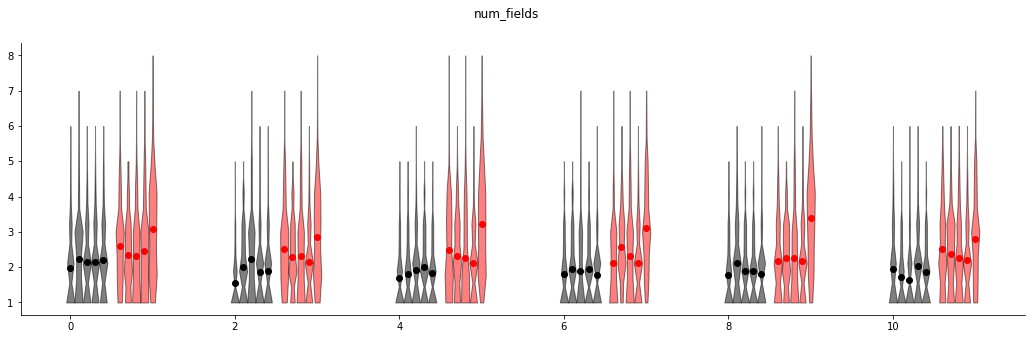

In [6]:
fig,ax = fam_cell_stats.violin_plots('num_fields')
fam_cell_stats.mixed_anova('num_fields')
# fig.savefig(os.path.join(figdir, 'fam_max_counts_violin.pdf'),format = 'pdf')

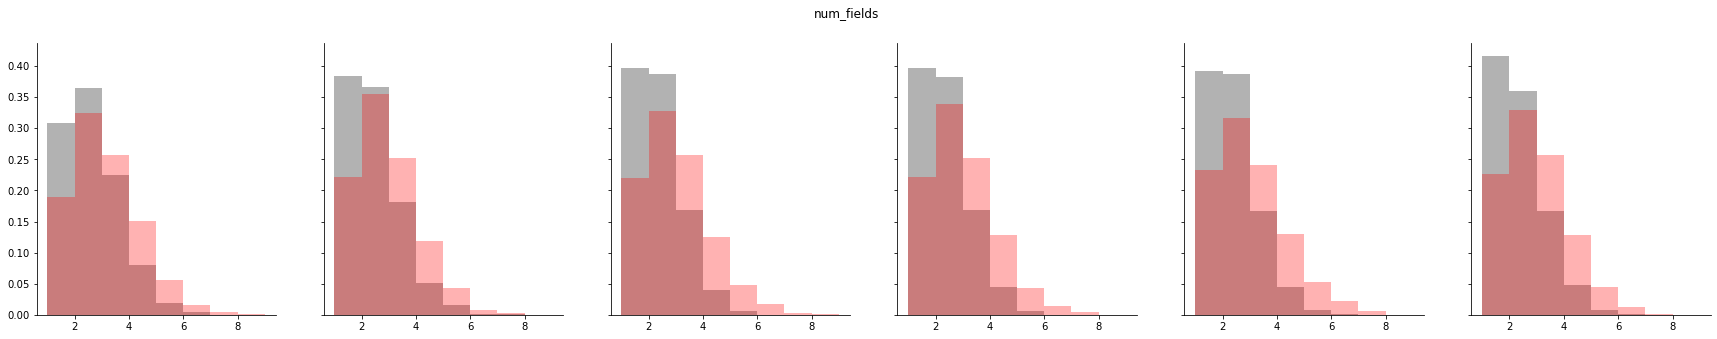

In [8]:
fig, ax = fam_cell_stats.combined_hist('num_fields', cumulative=False, smooth=False, bins = np.arange(1,10))
fig.savefig(os.path.join(figdir, 'fam_num_fields_hist.pdf'),format = 'pdf')

Mixed design ANOVA results
        Source        SS  DF1  DF2        MS         F     p-unc       np2  \
0      ko_ctrl  0.034754    1    8  0.034754  1.947050  0.200420  0.195741   
1          day  0.010062    5   40  0.002012  1.621845  0.176454  0.168559   
2  Interaction  0.002959    5   40  0.000592  0.476849  0.791311  0.056253   

        eps  
0       NaN  
1  0.469257  
2       NaN  
PostHoc Tukey: KO vs Ctrl
   A  B   mean(A)   mean(B)      diff        se         T   p-tukey    hedges
0  0  1 -0.015397 -0.063531  0.048135  0.015367  3.132284  0.002718  0.798249
PostHov Tukey on each day
Day 0
   A  B   mean(A)   mean(B)      diff        se         T   p-tukey    hedges
0  0  1 -0.013043 -0.043713  0.030669  0.034435  0.890645  0.399111  0.508781
Day 1
   A  B   mean(A)   mean(B)      diff        se         T   p-tukey    hedges
0  0  1 -0.004401 -0.073365  0.068964  0.034847  1.979027  0.083173  1.130519
Day 2
   A  B  mean(A)   mean(B)      diff        se         T   p-tukey

{'anova':         Source        SS  DF1  DF2        MS         F     p-unc       np2  \
 0      ko_ctrl  0.034754    1    8  0.034754  1.947050  0.200420  0.195741   
 1          day  0.010062    5   40  0.002012  1.621845  0.176454  0.168559   
 2  Interaction  0.002959    5   40  0.000592  0.476849  0.791311  0.056253   
 
         eps  
 0       NaN  
 1  0.469257  
 2       NaN  ,
 'ko_ctrl_tukey':    A  B   mean(A)   mean(B)      diff        se         T   p-tukey    hedges
 0  0  1 -0.015397 -0.063531  0.048135  0.015367  3.132284  0.002718  0.798249,
 'day_tukey': [   A  B   mean(A)   mean(B)      diff        se         T   p-tukey    hedges
  0  0  1 -0.013043 -0.043713  0.030669  0.034435  0.890645  0.399111  0.508781,
     A  B   mean(A)   mean(B)      diff        se         T   p-tukey    hedges
  0  0  1 -0.004401 -0.073365  0.068964  0.034847  1.979027  0.083173  1.130519,
     A  B  mean(A)   mean(B)      diff        se         T   p-tukey  hedges
  0  0  1 -0.03138 -0.08

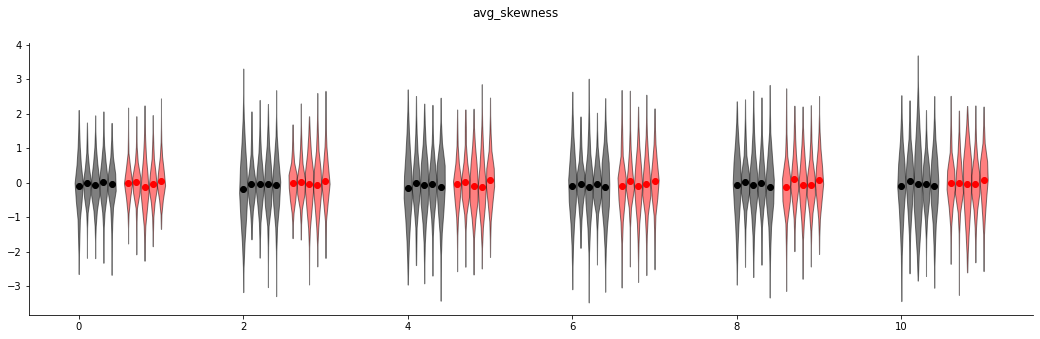

In [26]:
fig,ax = fam_cell_stats.violin_plots('avg_skewness')
fam_cell_stats.mixed_anova('avg_skewness')

Mixed design ANOVA results
        Source        SS  DF1  DF2        MS          F         p-unc  \
0      ko_ctrl  1.068538    1    8  1.068538   6.490086  3.430445e-02   
1          day  1.647648    5   40  0.329530  13.120973  1.391515e-07   
2  Interaction  0.094993    5   40  0.018999   0.756469  5.864374e-01   

        np2       eps  
0  0.447898       NaN  
1  0.621230  0.477734  
2  0.086390       NaN  
PostHoc Tukey: KO vs Ctrl
   A  B   mean(A)   mean(B)      diff       se         T  p-tukey    hedges
0  0  1  2.534523  2.801423 -0.266901  0.06835 -3.904926    0.001 -0.995153
PostHov Tukey on each day
Day 0
   A  B   mean(A)   mean(B)      diff        se         T   p-tukey    hedges
0  0  1  2.251932  2.445312 -0.193381  0.101779 -1.900007  0.093966 -1.085379
Day 1
   A  B   mean(A)   mean(B)     diff        se         T   p-tukey    hedges
0  0  1  2.451096  2.749516 -0.29842  0.188064 -1.586802  0.151218 -0.906461
Day 2
   A  B   mean(A)   mean(B)      diff       se      

{'anova':         Source        SS  DF1  DF2        MS          F         p-unc  \
 0      ko_ctrl  1.068538    1    8  1.068538   6.490086  3.430445e-02   
 1          day  1.647648    5   40  0.329530  13.120973  1.391515e-07   
 2  Interaction  0.094993    5   40  0.018999   0.756469  5.864374e-01   
 
         np2       eps  
 0  0.447898       NaN  
 1  0.621230  0.477734  
 2  0.086390       NaN  ,
 'ko_ctrl_tukey':    A  B   mean(A)   mean(B)      diff       se         T  p-tukey    hedges
 0  0  1  2.534523  2.801423 -0.266901  0.06835 -3.904926    0.001 -0.995153,
 'day_tukey': [   A  B   mean(A)   mean(B)      diff        se         T   p-tukey    hedges
  0  0  1  2.251932  2.445312 -0.193381  0.101779 -1.900007  0.093966 -1.085379,
     A  B   mean(A)   mean(B)     diff        se         T   p-tukey    hedges
  0  0  1  2.451096  2.749516 -0.29842  0.188064 -1.586802  0.151218 -0.906461,
     A  B   mean(A)   mean(B)      diff       se        T   p-tukey    hedges
  0  0  1

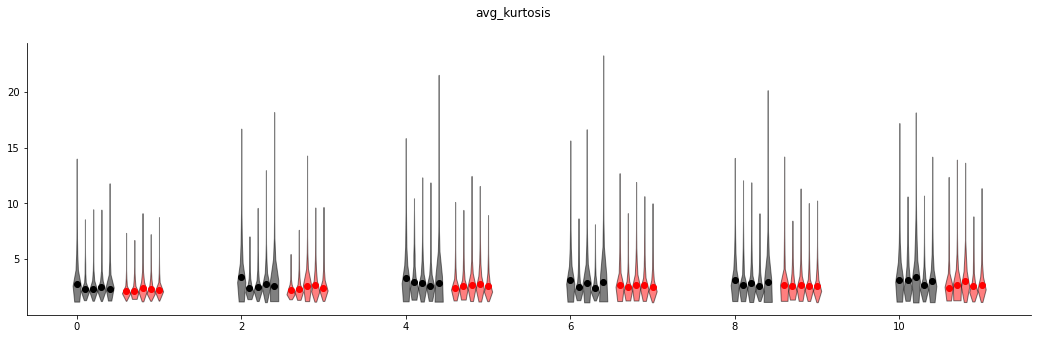

In [32]:
fig,ax = fam_cell_stats.violin_plots('avg_kurtosis')
fam_cell_stats.mixed_anova('avg_kurtosis')

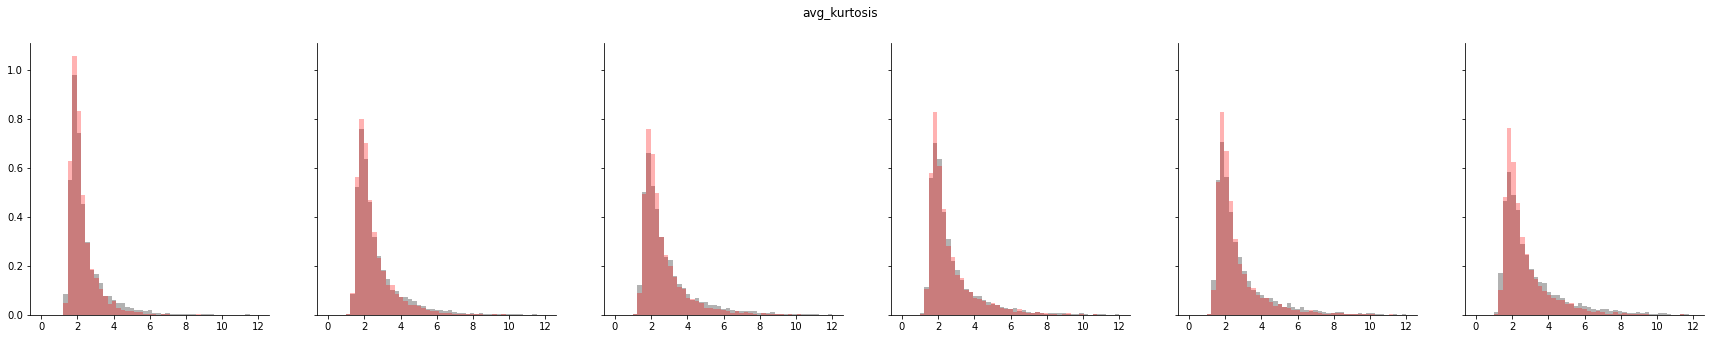

In [73]:
fig, ax = fam_cell_stats.combined_hist('avg_kurtosis', cumulative=False, smooth=False, bins=np.linspace(0,12))

/home/mplitt/repos/STX3KO_analyses/STX3KO_analyses/single_cell_stats.py:304: RuntimeWarning: Mean of empty slice
  ko_mu, ko_sem = np.nanmean(ko_mu_arr, axis=0), sp.stats.sem(ko_mu_arr, axis=0, nan_policy='omit')
/home/mplitt/repos/STX3KO_analyses/STX3KO_analyses/single_cell_stats.py:305: RuntimeWarning: Mean of empty slice
  ctrl_mu, ctrl_sem = np.nanmean(ctrl_mu_arr, axis=0), sp.stats.sem(ctrl_mu_arr, axis=0, nan_policy='omit')


(<Figure size 2160x720 with 12 Axes>,
 array([[<AxesSubplot:xlabel='Trial #', ylabel='skewness'>,
         <AxesSubplot:xlabel='Trial #', ylabel='skewness'>,
         <AxesSubplot:xlabel='Trial #', ylabel='skewness'>,
         <AxesSubplot:xlabel='Trial #', ylabel='skewness'>,
         <AxesSubplot:xlabel='Trial #', ylabel='skewness'>,
         <AxesSubplot:xlabel='Trial #', ylabel='skewness'>],
        [<AxesSubplot:xlabel='Trial #', ylabel='skewness'>,
         <AxesSubplot:xlabel='Trial #', ylabel='skewness'>,
         <AxesSubplot:xlabel='Trial #', ylabel='skewness'>,
         <AxesSubplot:xlabel='Trial #', ylabel='skewness'>,
         <AxesSubplot:xlabel='Trial #', ylabel='skewness'>,
         <AxesSubplot:xlabel='Trial #', ylabel='skewness'>]], dtype=object))

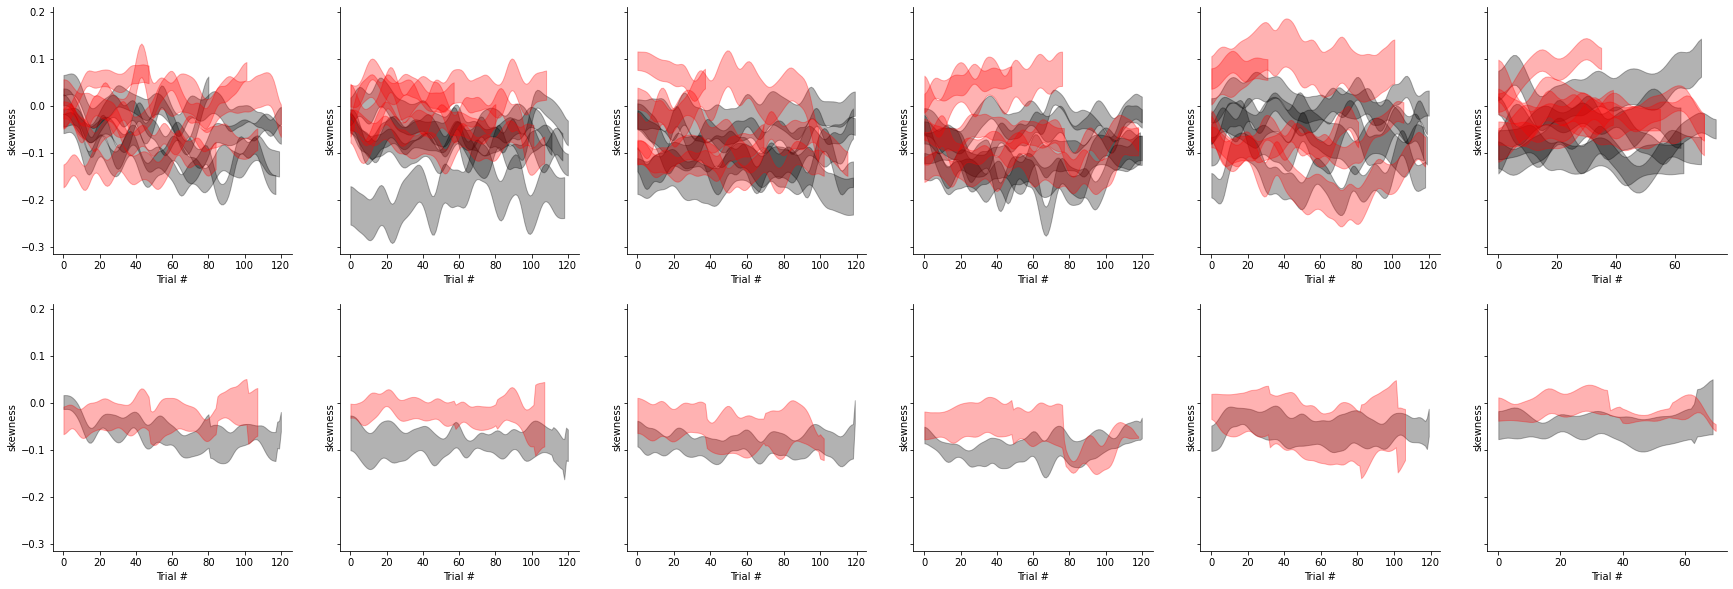

In [27]:
fam_cell_stats.across_trial_plot('skewness')

In [9]:
nov_cell_stats = CellStats(fam=False)

{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 6, 'scan': 14, 'novel_arm': -1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 6}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 0}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 9, 'novel_arm': 1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', '

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


Mixed design ANOVA results
        Source        SS  DF1  DF2        MS          F     p-unc       np2  \
0      ko_ctrl  2.722317    1    8  2.722317  18.386612  0.002659  0.696816   
1          day  0.707231    5   40  0.141446   5.698823  0.000464  0.416008   
2  Interaction  0.127781    5   40  0.025556   1.029653  0.413430  0.114030   

        eps  
0       NaN  
1  0.570457  
2       NaN  
PostHoc Tukey: KO vs Ctrl
   A  B   mean(A)   mean(B)      diff        se         T  p-tukey    hedges
0  0  1  7.803159  7.377145  0.426014  0.058842  7.239927    0.001  1.845064
PostHov Tukey on each day
Day 0
   A  B   mean(A)  mean(B)      diff        se         T   p-tukey    hedges
0  0  1  7.945582  7.45417  0.491412  0.155399  3.162261  0.013351  1.806442
Day 1
   A  B   mean(A)   mean(B)      diff       se         T   p-tukey    hedges
0  0  1  7.764424  7.348038  0.416386  0.10945  3.804352  0.005204  2.173237
Day 2
   A  B   mean(A)   mean(B)      diff        se         T   p-tukey 

{'anova':         Source        SS  DF1  DF2        MS          F     p-unc       np2  \
 0      ko_ctrl  2.722317    1    8  2.722317  18.386612  0.002659  0.696816   
 1          day  0.707231    5   40  0.141446   5.698823  0.000464  0.416008   
 2  Interaction  0.127781    5   40  0.025556   1.029653  0.413430  0.114030   
 
         eps  
 0       NaN  
 1  0.570457  
 2       NaN  ,
 'ko_ctrl_tukey':    A  B   mean(A)   mean(B)      diff        se         T  p-tukey    hedges
 0  0  1  7.803159  7.377145  0.426014  0.058842  7.239927    0.001  1.845064,
 'day_tukey': [   A  B   mean(A)  mean(B)      diff        se         T   p-tukey    hedges
  0  0  1  7.945582  7.45417  0.491412  0.155399  3.162261  0.013351  1.806442,
     A  B   mean(A)   mean(B)      diff       se         T   p-tukey    hedges
  0  0  1  7.764424  7.348038  0.416386  0.10945  3.804352  0.005204  2.173237,
     A  B   mean(A)   mean(B)      diff        se         T   p-tukey    hedges
  0  0  1  7.726642  7.

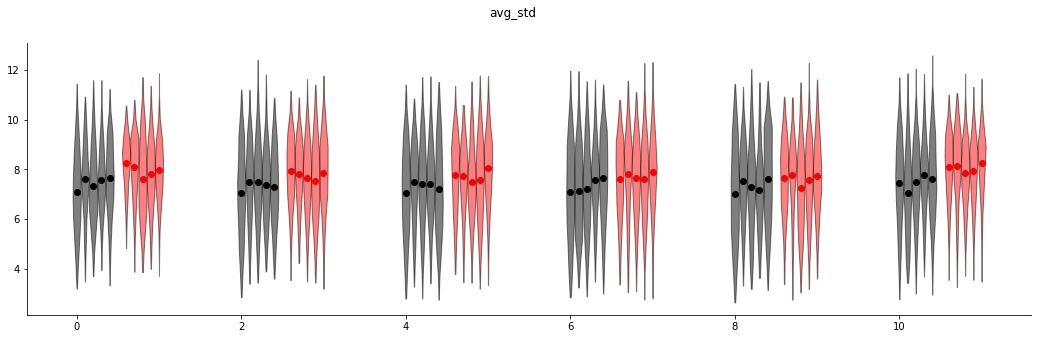

In [29]:
fig,ax = nov_cell_stats.violin_plots('avg_std')
nov_cell_stats.mixed_anova('avg_std')
# fig.savefig(os.path.join(figdir, 'nov_avg_std_violin.pdf'),format = 'pdf')

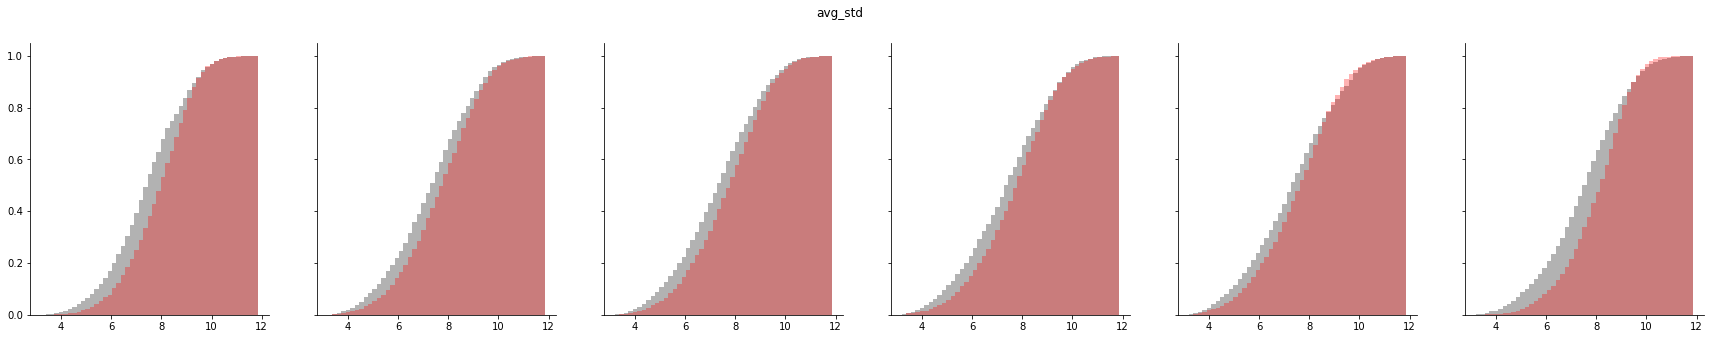

In [46]:
fig, ax = nov_cell_stats.combined_hist('avg_std', cumulative=True, smooth=False)
fig.savefig(os.path.join(figdir, 'nov_avg_std_cumhist.pdf'),format = 'pdf')

Mixed design ANOVA results
        Source         SS  DF1  DF2         MS          F     p-unc       np2  \
0      ko_ctrl  17.528132    1    8  17.528132  11.913427  0.008675  0.598261   
1          day   1.011448    5   40   0.202290   3.061769  0.019679  0.276788   
2  Interaction   0.261932    5   40   0.052386   0.792899  0.561170  0.090175   

        eps  
0       NaN  
1  0.684133  
2       NaN  
PostHoc Tukey: KO vs Ctrl
   A  B  mean(A)   mean(B)      diff        se         T  p-tukey    hedges
0  0  1   4.9056  5.986591 -1.080991  0.134278 -8.050425    0.001 -2.051616
PostHov Tukey on each day
Day 0
   A  B   mean(A)   mean(B)     diff        se         T   p-tukey    hedges
0  0  1  4.850174  5.863484 -1.01331  0.334641 -3.028055  0.016358 -1.729777
Day 1
   A  B   mean(A)   mean(B)      diff      se         T   p-tukey    hedges
0  0  1  4.915144  5.816548 -0.901404  0.3734 -2.414045  0.042239 -1.379023
Day 2
   A  B   mean(A)   mean(B)      diff        se        T  p-tuke

{'anova':         Source         SS  DF1  DF2         MS          F     p-unc       np2  \
 0      ko_ctrl  17.528132    1    8  17.528132  11.913427  0.008675  0.598261   
 1          day   1.011448    5   40   0.202290   3.061769  0.019679  0.276788   
 2  Interaction   0.261932    5   40   0.052386   0.792899  0.561170  0.090175   
 
         eps  
 0       NaN  
 1  0.684133  
 2       NaN  ,
 'ko_ctrl_tukey':    A  B  mean(A)   mean(B)      diff        se         T  p-tukey    hedges
 0  0  1   4.9056  5.986591 -1.080991  0.134278 -8.050425    0.001 -2.051616,
 'day_tukey': [   A  B   mean(A)   mean(B)     diff        se         T   p-tukey    hedges
  0  0  1  4.850174  5.863484 -1.01331  0.334641 -3.028055  0.016358 -1.729777,
     A  B   mean(A)   mean(B)      diff      se         T   p-tukey    hedges
  0  0  1  4.915144  5.816548 -0.901404  0.3734 -2.414045  0.042239 -1.379023,
     A  B   mean(A)   mean(B)      diff        se        T  p-tukey   hedges
  0  0  1  4.891419  5

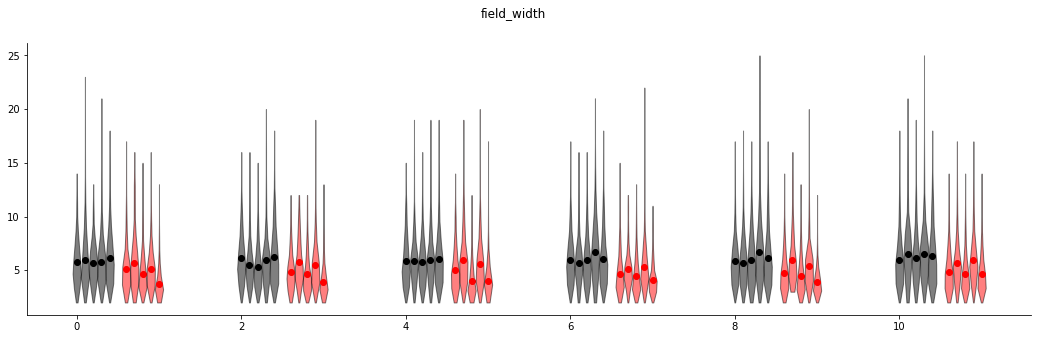

In [31]:
fig,ax = nov_cell_stats.violin_plots('field_width')
nov_cell_stats.mixed_anova('field_width')
# fig.savefig(os.path.join(figdir, 'nov_field_width_violin.pdf'),format = 'pdf')

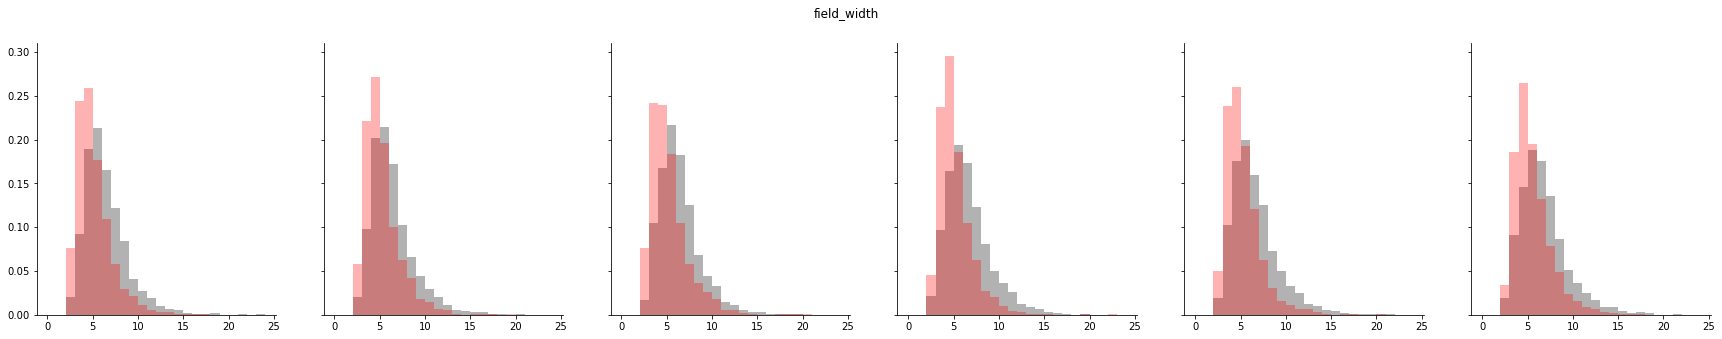

In [42]:
fig, ax = nov_cell_stats.combined_hist('field_width', cumulative=False, smooth=False, bins = np.arange(0,25))
fig.savefig(os.path.join(figdir, 'nov_field_width_hist.pdf'),format = 'pdf')

Mixed design ANOVA results
        Source        SS  DF1  DF2        MS          F     p-unc       np2  \
0      ko_ctrl  8.839904    1    8  8.839904  14.135573  0.005546  0.638591   
1          day  0.862700    5   40  0.172540   3.473845  0.010612  0.302762   
2  Interaction  0.085674    5   40  0.017135   0.344987  0.882414  0.041341   

      eps  
0     NaN  
1  0.7302  
2     NaN  
PostHoc Tukey: KO vs Ctrl
   A  B   mean(A)  mean(B)      diff        se         T  p-tukey    hedges
0  0  1  2.785466  2.01779  0.767676  0.095521  8.036766    0.001  2.048135
PostHov Tukey on each day
Day 0
   A  B   mean(A)   mean(B)      diff       se         T   p-tukey    hedges
0  0  1  2.916478  2.173431  0.743047  0.25981  2.859967  0.021155  1.633757
Day 1
   A  B   mean(A)   mean(B)      diff        se         T   p-tukey   hedges
0  0  1  2.812419  2.064347  0.748072  0.201857  3.705942  0.005991  2.11702
Day 2
   A  B   mean(A)   mean(B)     diff        se         T   p-tukey    hedges
0

{'anova':         Source        SS  DF1  DF2        MS          F     p-unc       np2  \
 0      ko_ctrl  8.839904    1    8  8.839904  14.135573  0.005546  0.638591   
 1          day  0.862700    5   40  0.172540   3.473845  0.010612  0.302762   
 2  Interaction  0.085674    5   40  0.017135   0.344987  0.882414  0.041341   
 
       eps  
 0     NaN  
 1  0.7302  
 2     NaN  ,
 'ko_ctrl_tukey':    A  B   mean(A)  mean(B)      diff        se         T  p-tukey    hedges
 0  0  1  2.785466  2.01779  0.767676  0.095521  8.036766    0.001  2.048135,
 'day_tukey': [   A  B   mean(A)   mean(B)      diff       se         T   p-tukey    hedges
  0  0  1  2.916478  2.173431  0.743047  0.25981  2.859967  0.021155  1.633757,
     A  B   mean(A)   mean(B)      diff        se         T   p-tukey   hedges
  0  0  1  2.812419  2.064347  0.748072  0.201857  3.705942  0.005991  2.11702,
     A  B   mean(A)   mean(B)     diff        se         T   p-tukey    hedges
  0  0  1  2.941739  2.018149  0.9

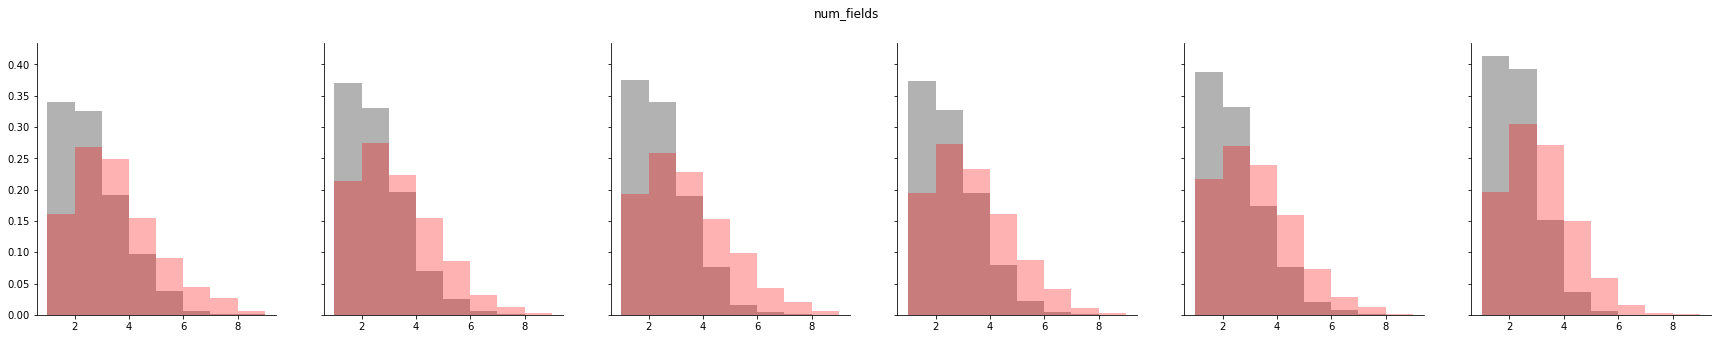

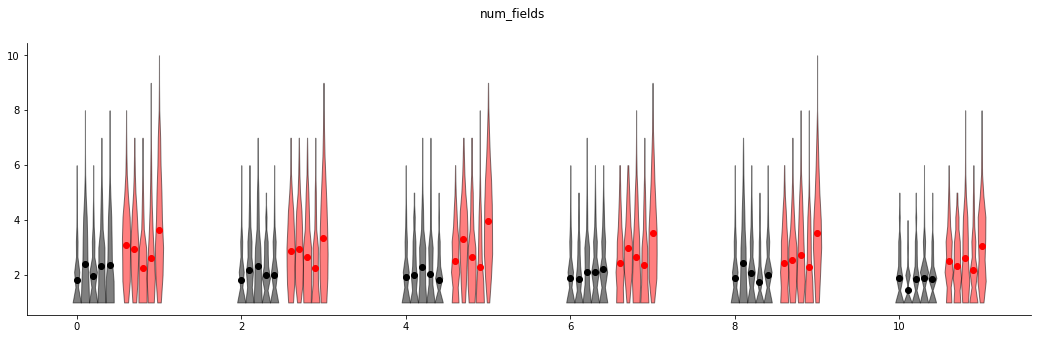

In [10]:
fig, ax = nov_cell_stats.combined_hist('num_fields', cumulative=False, smooth=False, bins = np.arange(1,10))
fig.savefig(os.path.join(figdir, 'nov_num_fields_hist.pdf'),format = 'pdf')
fig,ax = nov_cell_stats.violin_plots('num_fields')
nov_cell_stats.mixed_anova('num_fields')

Mixed design ANOVA results
        Source        SS  DF1  DF2        MS         F     p-unc       np2  \
0      ko_ctrl  0.211120    1    8  0.211120  5.227719  0.051552  0.395209   
1          day  0.004540    5   40  0.000908  0.229448  0.947459  0.027881   
2  Interaction  0.004314    5   40  0.000863  0.218001  0.952759  0.026527   

        eps  
0       NaN  
1  0.664937  
2       NaN  
PostHoc Tukey: KO vs Ctrl
   A  B   mean(A)   mean(B)      diff        se         T  p-tukey    hedges
0  0  1  0.028005 -0.090632  0.118637  0.023738  4.997737    0.001  1.273652
PostHov Tukey on each day
Day 0
   A  B   mean(A)   mean(B)      diff        se         T   p-tukey    hedges
0  0  1  0.035638 -0.078926  0.114564  0.047205  2.426936  0.041401  1.386388
Day 1
   A  B   mean(A)   mean(B)      diff        se         T   p-tukey    hedges
0  0  1  0.025617 -0.092272  0.117889  0.068367  1.724357  0.122929  0.985039
Day 2
   A  B   mean(A)   mean(B)      diff        se       T   p-tukey   

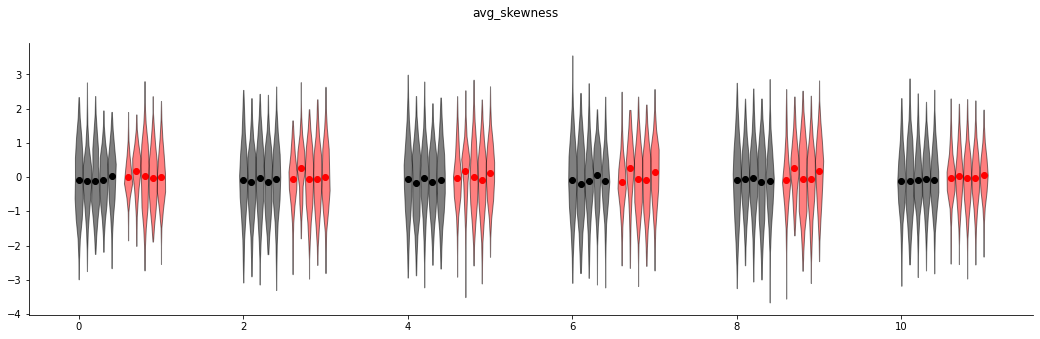

In [35]:
nov_cell_stats.mixed_anova('avg_skewness')
fig, ax = nov_cell_stats.violin_plots('avg_skewness')

Mixed design ANOVA results
        Source        SS  DF1  DF2        MS         F     p-unc       np2  \
0      ko_ctrl  2.695590    1    8  2.695590  9.578240  0.014780  0.544892   
1          day  1.756275    5   40  0.351255  8.914741  0.000009  0.527040   
2  Interaction  0.087548    5   40  0.017510  0.444387  0.814746  0.052625   

        eps  
0       NaN  
1  0.500399  
2       NaN  
PostHoc Tukey: KO vs Ctrl
   A  B   mean(A)   mean(B)      diff        se         T  p-tukey    hedges
0  0  1  2.866806  3.290724 -0.423917  0.080739 -5.250481    0.001 -1.338062
PostHov Tukey on each day
Day 0
   A  B  mean(A)  mean(B)     diff        se         T   p-tukey    hedges
0  0  1  2.62799  3.05683 -0.42884  0.215956 -1.985777  0.082308 -1.134375
Day 1
   A  B   mean(A)   mean(B)      diff        se         T   p-tukey    hedges
0  0  1  2.878367  3.336915 -0.458548  0.147851 -3.101421  0.014632 -1.771687
Day 2
   A  B   mean(A)   mean(B)      diff        se         T   p-tukey    hed

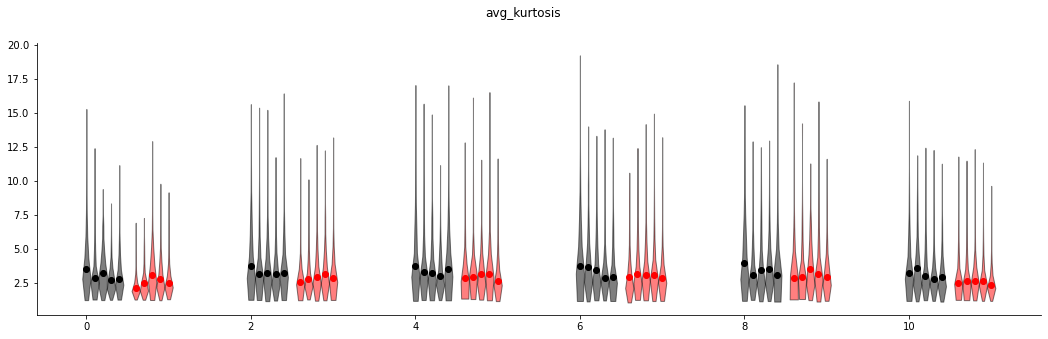

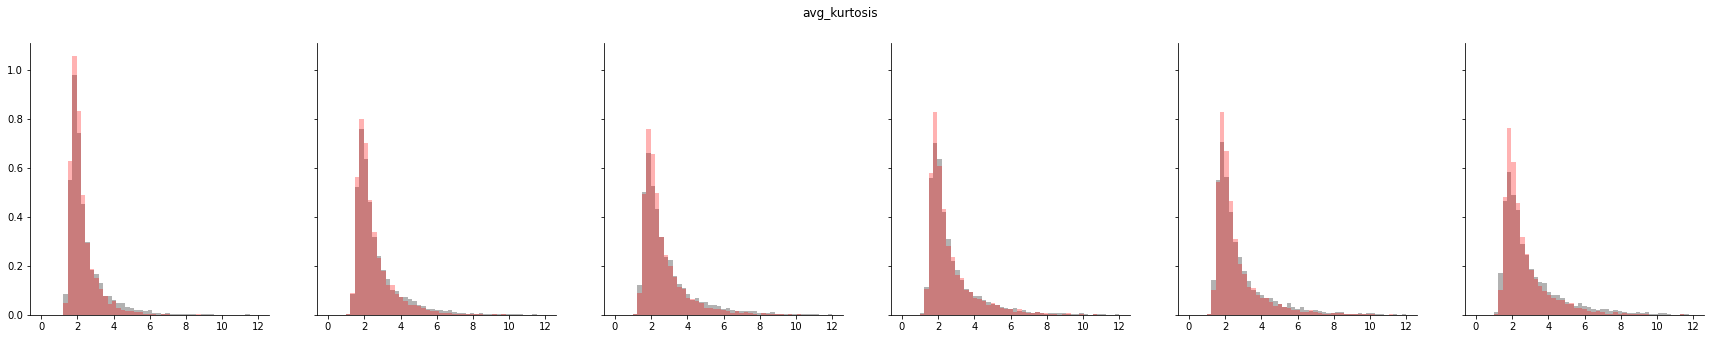

In [75]:
nov_cell_stats.mixed_anova('avg_kurtosis')
fig, ax = nov_cell_stats.violin_plots('avg_kurtosis')
fig, ax = fam_cell_stats.combined_hist('avg_kurtosis', cumulative=False, smooth=False, bins = np.linspace(0,12))

/home/mplitt/repos/STX3KO_analyses/STX3KO_analyses/single_cell_stats.py:304: RuntimeWarning: Mean of empty slice
  ko_mu, ko_sem = np.nanmean(ko_mu_arr, axis=0), sp.stats.sem(ko_mu_arr, axis=0, nan_policy='omit')
/home/mplitt/repos/STX3KO_analyses/STX3KO_analyses/single_cell_stats.py:305: RuntimeWarning: Mean of empty slice
  ctrl_mu, ctrl_sem = np.nanmean(ctrl_mu_arr, axis=0), sp.stats.sem(ctrl_mu_arr, axis=0, nan_policy='omit')


(<Figure size 2160x720 with 12 Axes>,
 array([[<AxesSubplot:xlabel='Trial #', ylabel='skewness'>,
         <AxesSubplot:xlabel='Trial #', ylabel='skewness'>,
         <AxesSubplot:xlabel='Trial #', ylabel='skewness'>,
         <AxesSubplot:xlabel='Trial #', ylabel='skewness'>,
         <AxesSubplot:xlabel='Trial #', ylabel='skewness'>,
         <AxesSubplot:xlabel='Trial #', ylabel='skewness'>],
        [<AxesSubplot:xlabel='Trial #', ylabel='skewness'>,
         <AxesSubplot:xlabel='Trial #', ylabel='skewness'>,
         <AxesSubplot:xlabel='Trial #', ylabel='skewness'>,
         <AxesSubplot:xlabel='Trial #', ylabel='skewness'>,
         <AxesSubplot:xlabel='Trial #', ylabel='skewness'>,
         <AxesSubplot:xlabel='Trial #', ylabel='skewness'>]], dtype=object))

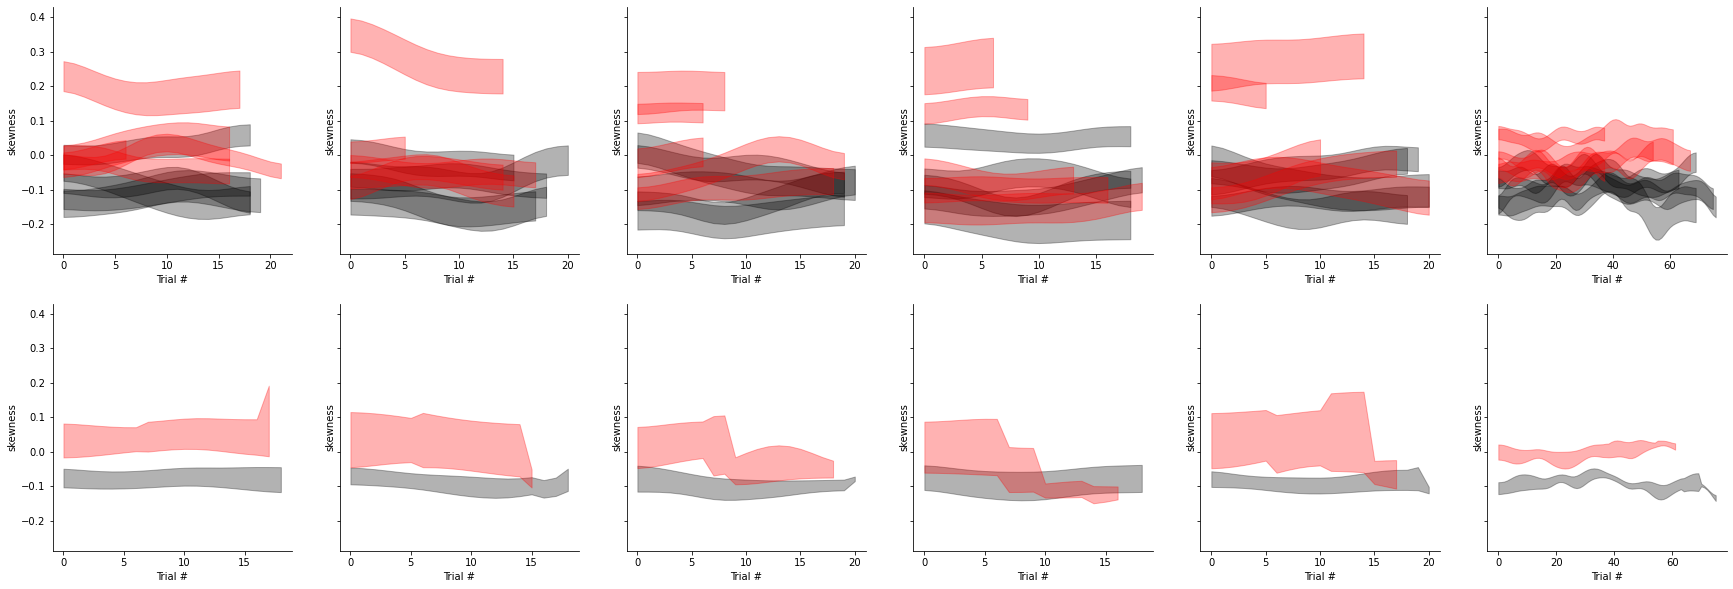

In [36]:
nov_cell_stats.across_trial_plot('skewness')